In [1]:
#!/usr/bin/python

import sys
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

from time import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from dos2unix import crlf_to_lf

# from class_vis import prettyPicture
# from tester import dump_classifier_and_data

In [2]:
### Load the dictionary containing the dataset
data_dict = None
fp = crlf_to_lf(f_in_path='final_project_dataset.pkl')
with open(fp, 'rb') as data_file:
    data_dict = pickle.load(data_file)
    
### Make it a dataframe because they're easier to work with.
data_df = pd.DataFrame(data_dict).T

final_project_dataset.pkl saved as final_project_dataset_unix.pkl in 6705 bytes.


### Clean up
Get to a point where I can run a rough baseline model (clean and impute with zeroes).

In [8]:
### Drop email_address since it's a signature.
data_df.drop(columns='email_address', inplace=True)

### Drop the TOTAL row.
data_df.drop(labels=['TOTAL', 'THE TRAVEL AGENCY IN THE PARK'], inplace=True)

### Handle missing values. (Will impute later.)
### Replacing 'NaN' with None had a weird result in which values from some
### rows were copied into the missing values of neighboring rows. No idea why.
### Using np.nan did not have that result as far as I can tell.
### But it is a float missing value and thus casts the column as
### float or object when other values are not floats.
data_df.replace(to_replace='NaN', value=np.nan, inplace=True)

In [9]:
(~data_df.isna()).sum().sum()
(data_df.isna()).sum().sum()
data_df.info()
data_df.describe()
data_df.head()

1579

1301

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, METTS MARK to GLISAN JR BEN F
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   salary                     94 non-null     float64
 1   to_messages                86 non-null     float64
 2   deferral_payments          38 non-null     float64
 3   total_payments             123 non-null    float64
 4   loan_advances              3 non-null      float64
 5   bonus                      81 non-null     float64
 6   restricted_stock_deferred  17 non-null     float64
 7   deferred_income            48 non-null     float64
 8   total_stock_value          125 non-null    float64
 9   expenses                   94 non-null     float64
 10  from_poi_to_this_person    86 non-null     float64
 11  exercised_stock_options    101 non-null    float64
 12  from_messages              86 non-null     float64
 13  other                      91 non-

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
count,9.400000e+01,86.000000,3.800000e+01,1.230000e+02,3.000000e+00,8.100000e+01,1.700000e+01,4.800000e+01,1.250000e+02,94.000000,86.000000,1.010000e+02,86.000000,9.100000e+01,86.000000,6.500000e+01,86.000000,1.090000e+02,16.000000
mean,2.840875e+05,2073.860465,8.416025e+05,2.641806e+06,2.797500e+07,1.201773e+06,6.218928e+05,-5.810498e+05,3.352073e+06,54192.010638,64.895349,2.959559e+06,608.790698,4.664105e+05,41.232558,7.464912e+05,1176.465116,1.147424e+06,89822.875000
std,1.771311e+05,2582.700981,1.289323e+06,9.524694e+06,4.638256e+07,1.441679e+06,3.845528e+06,9.420764e+05,6.532883e+06,46108.377454,86.979244,5.499450e+06,1841.033949,1.397376e+06,100.073111,8.629174e+05,1178.317641,2.249770e+06,41112.700735
min,4.770000e+02,57.000000,-1.025000e+05,1.480000e+02,4.000000e+05,7.000000e+04,-1.787380e+06,-3.504386e+06,-4.409300e+04,148.000000,0.000000,3.285000e+03,12.000000,2.000000e+00,0.000000,6.922300e+04,2.000000,-2.604490e+06,3285.000000
25%,2.118020e+05,541.250000,7.964450e+04,3.969340e+05,1.200000e+06,4.250000e+05,-3.298250e+05,-6.112092e+05,4.941360e+05,22479.000000,10.000000,5.067650e+05,22.750000,1.203000e+03,1.000000,2.750000e+05,249.750000,2.520550e+05,83674.500000
50%,2.587410e+05,1211.000000,2.210635e+05,1.101393e+06,2.000000e+06,7.500000e+05,-1.402640e+05,-1.519270e+05,1.095040e+06,46547.500000,35.000000,1.297049e+06,41.000000,5.158700e+04,8.000000,4.221580e+05,740.500000,4.410960e+05,106164.500000
75%,3.086065e+05,2634.750000,8.672112e+05,2.087530e+06,4.176250e+07,1.200000e+06,-7.241900e+04,-3.792600e+04,2.606763e+06,78408.500000,72.250000,2.542813e+06,145.500000,3.319830e+05,24.750000,8.318090e+05,1888.250000,9.850320e+05,112815.000000
max,1.111258e+06,15149.000000,6.426990e+06,1.035598e+08,8.152500e+07,8.000000e+06,1.545629e+07,-8.330000e+02,4.911008e+07,228763.000000,528.000000,3.434838e+07,14368.000000,1.035973e+07,609.000000,5.145434e+06,5521.000000,1.476169e+07,137864.000000


,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
METTS MARK,365788.0,807.0,NaN,1061827.0,NaN,600000.0,NaN,NaN,585062.0,94299.0,38.0,NaN,29.0,1740.0,1.0,False,NaN,702.0,585062.0,NaN
BAXTER JOHN C,267102.0,NaN,1295738.0,5634343.0,NaN,1200000.0,NaN,-1386055.0,10623258.0,11200.0,NaN,6680544.0,NaN,2660303.0,NaN,False,1586055.0,NaN,3942714.0,NaN
ELLIOTT STEVEN,170941.0,NaN,NaN,211725.0,NaN,350000.0,NaN,-400729.0,6678735.0,78552.0,NaN,4890344.0,NaN,12961.0,NaN,False,NaN,NaN,1788391.0,NaN
CORDES WILLIAM R,NaN,764.0,NaN,NaN,NaN,NaN,NaN,NaN,1038185.0,NaN,10.0,651850.0,12.0,NaN,0.0,False,NaN,58.0,386335.0,NaN
HANNON KEVIN P,243293.0,1045.0,NaN,288682.0,NaN,1500000.0,NaN,-3117011.0,6391065.0,34039.0,32.0,5538001.0,32.0,11350.0,21.0,True,1617011.0,1035.0,853064.0,NaN


In [5]:
data_df[data_df['poi'] == 1]['other'].describe()
data_df[data_df['poi'] == 0]['other'].describe()

count    1.800000e+01
mean     8.029974e+05
std      2.417568e+06
min      4.860000e+02
25%      4.979500e+03
50%      1.492040e+05
75%      2.607725e+05
max      1.035973e+07
Name: other, dtype: float64

count    7.300000e+01
mean     3.834165e+05
std      1.012686e+06
min      2.000000e+00
25%      9.470000e+02
50%      1.296100e+04
75%      3.746890e+05
max      7.427621e+06
Name: other, dtype: float64

In [6]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi"
###    (if using featureFormat(), which I probably won't).

### All units are in USD.
fin_features = ['salary', 'bonus', 'long_term_incentive', 'deferred_income',
                'deferral_payments', 'loan_advances', 'other', 'expenses',
                'director_fees', 'total_payments', 'exercised_stock_options',
                'restricted_stock', 'restricted_stock_deferred',
                'total_stock_value']
    
### Units are generally number of emails messages;
### notable exception is 'email_address', which is a text string, which I removed at the beginning.
email_features = ['to_messages', 'from_poi_to_this_person',
                  'from_messages', 'from_this_person_to_poi',
                  'shared_receipt_with_poi']

### Boolean, represented as integer.
POI_label = ['poi']

### Subsets of fin_features.
pay_features = fin_features[:10]
stock_features = fin_features[10:]

### The first feature must be "poi" if using featureFormat().
features_list = POI_label + fin_features + email_features

### Order columns to reflect FindLaw PDF column order.
data_df = data_df[features_list]

In [7]:
### Set data types, having already handled missing values.
data_df.dtypes

poi                             bool
salary                       float64
bonus                        float64
long_term_incentive          float64
deferred_income              float64
deferral_payments            float64
loan_advances                float64
other                        float64
expenses                     float64
director_fees                float64
total_payments               float64
exercised_stock_options      float64
restricted_stock             float64
restricted_stock_deferred    float64
total_stock_value            float64
to_messages                  float64
from_poi_to_this_person      float64
from_messages                float64
from_this_person_to_poi      float64
shared_receipt_with_poi      float64
dtype: object

In [8]:
### What do np.nans look like?
data_df['salary'].head()
data_df['salary'].describe()
### Should be float.
data_df['salary']['CORDES WILLIAM R']
type(data_df['salary']['CORDES WILLIAM R'])
data_df['salary']['METTS MARK']
type(data_df['salary']['METTS MARK'])

METTS MARK          365788.0
BAXTER JOHN C       267102.0
ELLIOTT STEVEN      170941.0
CORDES WILLIAM R         NaN
HANNON KEVIN P      243293.0
Name: salary, dtype: float64

count    9.400000e+01
mean     2.840875e+05
std      1.771311e+05
min      4.770000e+02
25%      2.118020e+05
50%      2.587410e+05
75%      3.086065e+05
max      1.111258e+06
Name: salary, dtype: float64

nan

numpy.float64

365788.0

numpy.float64

In [9]:

### I previously tried turning ints into nullable ints,
### but the associated pandas missing type does not play well with matplotlib.
### I'll leave missing type as np.nan and cast all features as floats.
### I don't think this will cause a problem. I can always change them to ints after imputation.
### I can make the label an int since there aren't any missing values.
### Hopefully sklearn can hang with the pandas nullable int missing value type.

### So, change only the poi.
data_df['poi'] = data_df['poi'].astype(dtype=int)
data_df['poi']
sum(data_df['poi'])

METTS MARK              0
BAXTER JOHN C           0
ELLIOTT STEVEN          0
CORDES WILLIAM R        0
HANNON KEVIN P          1
                       ..
GRAMM WENDY L           0
CAUSEY RICHARD A        1
TAYLOR MITCHELL S       0
DONAHUE JR JEFFREY M    0
GLISAN JR BEN F         1
Name: poi, Length: 144, dtype: int32

18

In [10]:
data_df.dtypes

poi                            int32
salary                       float64
bonus                        float64
long_term_incentive          float64
deferred_income              float64
deferral_payments            float64
loan_advances                float64
other                        float64
expenses                     float64
director_fees                float64
total_payments               float64
exercised_stock_options      float64
restricted_stock             float64
restricted_stock_deferred    float64
total_stock_value            float64
to_messages                  float64
from_poi_to_this_person      float64
from_messages                float64
from_this_person_to_poi      float64
shared_receipt_with_poi      float64
dtype: object

In [11]:
# ### Leave financial features as float,
# ### and change email features and poi to int.

# # data_df.loc[:, ~data_df.columns.isin(fin_features)].head()
# # data_df[data_df.columns.difference(fin_features)].head()
# # data_df.drop(fin_features, axis=1).head()

# int_feats_lst = email_features + POI_label
# data_df[int_feats_lst] = data_df[int_feats_lst].\
#     convert_dtypes(convert_boolean=False)

# data_df.dtypes

In [12]:
# data_df['salary'].head()
# data_df['salary'].describe()

In [13]:
# ### Floats remain consistent.
# data_df['salary']['CORDES WILLIAM R']
# type(data_df['salary']['CORDES WILLIAM R'])
# data_df['salary']['METTS MARK']
# type(data_df['salary']['METTS MARK'])

In [14]:
# data_df['to_messages'].head()
# data_df['to_messages'].describe()

In [15]:
# ### Cast to nullable Int64 with same missing type as string nulls.
# ### pandas._libs.missing.NAType
# ### Scalar values still stored as numpy.int64, consistent with floats.
# ### email_addresses aren't NumPy strings, but I'm not going to use them.
# data_df['to_messages']['BAXTER JOHN C']
# type(data_df['to_messages']['BAXTER JOHN C'])
# data_df['to_messages']['METTS MARK']
# type(data_df['to_messages']['METTS MARK'])

In [16]:
### Validate with total columns.
data_df.loc[data_df['total_payments'] != data_df[pay_features[:-1]].sum(axis='columns')]\
    .loc[data_df['total_payments'].isna() == False]
data_df.loc[data_df['total_stock_value'] != data_df[stock_features[:-1]].sum(axis='columns')]\
    .loc[data_df['total_stock_value'].isna() == False]

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi,shared_receipt_with_poi
BELFER ROBERT,0,NaN,NaN,NaN,NaN,-102500.0,NaN,NaN,NaN,3285.0,102500.0,3285.0,NaN,44093.0,-44093.0,NaN,NaN,NaN,NaN,NaN
BHATNAGAR SANJAY,0,NaN,NaN,NaN,NaN,NaN,NaN,137864.0,NaN,137864.0,15456290.0,2604490.0,-2604490.0,15456290.0,NaN,523.0,0.0,29.0,1.0,463.0


,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi,shared_receipt_with_poi
BELFER ROBERT,0,NaN,NaN,NaN,NaN,-102500.0,NaN,NaN,NaN,3285.0,102500.0,3285.0,NaN,44093.0,-44093.0,NaN,NaN,NaN,NaN,NaN


In [17]:
### Belfer's financial data is shifted one column to the right.
### Shift it one to the left, financial data only.
### Make total_stock_value np.nan for consistency until imputation,
### but could be 0.
### Will probably remove this row for so many nans, but fix it anyway.

data_df.loc[data_df.index == 'BELFER ROBERT', fin_features] = \
    data_df.loc[data_df.index == 'BELFER ROBERT', fin_features]\
        .shift(periods=-1, axis='columns', fill_value=np.nan)

data_df.loc['BELFER ROBERT']

poi                               0.0
salary                            NaN
bonus                             NaN
long_term_incentive               NaN
deferred_income             -102500.0
deferral_payments                 NaN
loan_advances                     NaN
other                             NaN
expenses                       3285.0
director_fees                102500.0
total_payments                 3285.0
exercised_stock_options           NaN
restricted_stock              44093.0
restricted_stock_deferred    -44093.0
total_stock_value                 NaN
to_messages                       NaN
from_poi_to_this_person           NaN
from_messages                     NaN
from_this_person_to_poi           NaN
shared_receipt_with_poi           NaN
Name: BELFER ROBERT, dtype: float64

In [18]:
### Bhatnagar's financial data is shifted one to the left.
### Shift it one to the right, financial data only.
### Make salary np.nan.

data_df.loc[data_df.index == 'BHATNAGAR SANJAY', fin_features] \
    = data_df.loc[data_df.index == 'BHATNAGAR SANJAY', fin_features]\
        .shift(periods=1, axis='columns', fill_value=np.nan)

data_df.loc['BHATNAGAR SANJAY']

poi                                 0.0
salary                              NaN
bonus                               NaN
long_term_incentive                 NaN
deferred_income                     NaN
deferral_payments                   NaN
loan_advances                       NaN
other                               NaN
expenses                       137864.0
director_fees                       NaN
total_payments                 137864.0
exercised_stock_options      15456290.0
restricted_stock              2604490.0
restricted_stock_deferred    -2604490.0
total_stock_value            15456290.0
to_messages                       523.0
from_poi_to_this_person             0.0
from_messages                      29.0
from_this_person_to_poi             1.0
shared_receipt_with_poi           463.0
Name: BHATNAGAR SANJAY, dtype: float64

In [19]:
### Check for nan salaries.
data_df[data_df['salary'].isna()].count()

poi                          50
salary                        0
bonus                         0
long_term_incentive           1
deferred_income              13
deferral_payments            11
loan_advances                 0
other                         2
expenses                     15
director_fees                15
total_payments               29
exercised_stock_options      29
restricted_stock             24
restricted_stock_deferred     8
total_stock_value            35
to_messages                  19
from_poi_to_this_person      19
from_messages                19
from_this_person_to_poi      19
shared_receipt_with_poi      19
dtype: int64

50 missing salaries. Were all persons salaried employees at some point? If I knew the answer to this I could confidently set salary and bonus to zeroes for nonemployees, which might affect which persons I remove for too many NaNs and how I impute other NaNs.

In [20]:
### Check for nan totals.
# data_df[data_df['total_payments'].isna()]
data_df.loc[(data_df['total_payments'].isna()) \
            & ~(data_df[pay_features].isna().all(axis='columns'))]

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi,shared_receipt_with_poi
CHAN RONNIE,0,NaN,NaN,NaN,-98784.0,NaN,NaN,NaN,NaN,98784.0,NaN,NaN,32460.0,-32460.0,NaN,NaN,NaN,NaN,NaN,NaN
POWERS WILLIAM,0,NaN,NaN,NaN,-17500.0,NaN,NaN,NaN,NaN,17500.0,NaN,NaN,NaN,NaN,NaN,653.0,0.0,26.0,0.0,12.0


In [21]:
data_df.loc[data_df['total_stock_value'].isna() \
        & ~(data_df[stock_features].isna().all(axis='columns'))]

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi,shared_receipt_with_poi
CHAN RONNIE,0,NaN,NaN,NaN,-98784.0,NaN,NaN,NaN,NaN,98784.0,NaN,NaN,32460.0,-32460.0,NaN,NaN,NaN,NaN,NaN,NaN
BELFER ROBERT,0,NaN,NaN,NaN,-102500.0,NaN,NaN,NaN,3285.0,102500.0,3285.0,NaN,44093.0,-44093.0,NaN,NaN,NaN,NaN,NaN,NaN
CARTER REBECCA C,0,261809.0,300000.0,75000.0,-159792.0,NaN,NaN,540.0,NaN,NaN,477557.0,NaN,307301.0,-307301.0,NaN,312.0,29.0,15.0,7.0,196.0


There are a few people who should have a number for totals because the constituent columns contain at least one number. In all cases, the nonNaN values sum to 0. Setting the totals here to 0 seems reasonable, but the other NaNs still give me pause.

I'll probably remove Chan and Belfer anyway due to excessive NaNs. I'll go ahead and set these values.

In [22]:
### Unintended effect of setting all totals to zero where all subvalues NaN.
# data_df['total_payments'] \
#     = data_df[pay_features[:-1]].sum(axis='columns')
# data_df['total_stock_value'] \
#     = data_df[stock_features[:-1]].sum(axis='columns')

data_df.loc[~(data_df[pay_features].isna().all(axis='columns')),
            'total_payments'] \
    = data_df[pay_features[:-1]].sum(axis='columns')
data_df.loc[~(data_df[stock_features].isna().all(axis='columns')),
            'total_stock_value'] \
    = data_df[stock_features[:-1]].sum(axis='columns')

In [23]:
data_df.loc['CHAN RONNIE'][['total_payments', 'total_stock_value']]
data_df.loc['POWERS WILLIAM'][['total_payments']]
data_df.loc['BELFER ROBERT'][['total_stock_value']]
data_df.loc['CARTER REBECCA C'][['total_stock_value']]

total_payments       0.0
total_stock_value    0.0
Name: CHAN RONNIE, dtype: float64

total_payments    0.0
Name: POWERS WILLIAM, dtype: float64

total_stock_value    0.0
Name: BELFER ROBERT, dtype: float64

total_stock_value    0.0
Name: CARTER REBECCA C, dtype: float64

In [24]:
### Check for 0 totals.
data_df[data_df['total_payments'] == 0]

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi,shared_receipt_with_poi
CHAN RONNIE,0,NaN,NaN,NaN,-98784.0,NaN,NaN,NaN,NaN,98784.0,0.0,NaN,32460.0,-32460.0,0.0,NaN,NaN,NaN,NaN,NaN
POWERS WILLIAM,0,NaN,NaN,NaN,-17500.0,NaN,NaN,NaN,NaN,17500.0,0.0,NaN,NaN,NaN,NaN,653.0,0.0,26.0,0.0,12.0


In [25]:
data_df[data_df['total_stock_value'] == 0]

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi,shared_receipt_with_poi
CHAN RONNIE,0,NaN,NaN,NaN,-98784.0,NaN,NaN,NaN,NaN,98784.0,0.0,NaN,32460.0,-32460.0,0.0,NaN,NaN,NaN,NaN,NaN
BELFER ROBERT,0,NaN,NaN,NaN,-102500.0,NaN,NaN,NaN,3285.0,102500.0,3285.0,NaN,44093.0,-44093.0,0.0,NaN,NaN,NaN,NaN,NaN
CARTER REBECCA C,0,261809.0,300000.0,75000.0,-159792.0,NaN,NaN,540.0,NaN,NaN,477557.0,NaN,307301.0,-307301.0,0.0,312.0,29.0,15.0,7.0,196.0


In [26]:
### Check for to/from inconsistencies (or fishy equality)
email_features
data_df[data_df['to_messages'] <= data_df['from_poi_to_this_person']]
data_df[data_df['to_messages'] <= data_df['shared_receipt_with_poi']]
data_df[data_df['from_messages'] <= data_df['from_this_person_to_poi']]

['to_messages',
 'from_poi_to_this_person',
 'from_messages',
 'from_this_person_to_poi',
 'shared_receipt_with_poi']

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi,shared_receipt_with_poi


,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi,shared_receipt_with_poi
GLISAN JR BEN F,1,274975.0,600000.0,71023.0,NaN,NaN,NaN,200308.0,125978.0,NaN,1272284.0,384728.0,393818.0,NaN,778546.0,873.0,52.0,16.0,6.0,874.0


,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi,shared_receipt_with_poi
HUMPHREY GENE E,0,130724.0,NaN,NaN,NaN,2964506.0,NaN,NaN,4994.0,NaN,3100224.0,2282768.0,NaN,NaN,2282768.0,128.0,10.0,17.0,17.0,119.0


GLISAN JR BEN F has 873 to messages but 874 shared receipts with POIs. An insignificant difference, I'll just add 1 to to_messages.

That said, it is a little weird that the only messages he received were shared with other POIs. If it's an error, it's one I will live with given the fact that there aren't so many NaNs in his row; if this is the only error in this row, hopefully the included information outweighs the noise.

One the other hand, given the fact that he's a POI, if this is an error, it could bias the model or inflate the results. For instance, I plan to make a feature that is a ratio of these values, and having a training POI with an erroneously high ratio might reduce POI recall and nonPOI precision in the test set. If he ends up in the test set, and if the model does learn that a higher ratio indicates a POI, then the error would be an easy and invalid win that inflates the test recall and nonPOI precision.

HUMPHREY GENE E appears to have only emailed POIs. That's weird but not a logic error. Again, if it's an error, hopefully the useful information included in this record outweighs the noise. And, since he's a nonPOI, hopefully it won't erroneously bias the model too much.

In [27]:
### Add one to Glisan's to_message to equal shared_receipt_with_poi.
data_df.loc['GLISAN JR BEN F', 'to_messages'] = 874
data_df.loc['GLISAN JR BEN F', 'to_messages']

874.0

In [28]:
### Any fishy mins or maxes?
for feature, min_val in data_df.describe().loc['min'].items():
    print('Min', feature, ':', min_val)
    print('Person:', data_df[data_df[feature] == min_val].index)

Min poi : 0.0
Person: Index(['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R',
       'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY',
       'HAEDICKE MARK E', 'PIPER GREGORY F', 'HUMPHREY GENE E',
       ...
       'FUGH JOHN L', 'SCRIMSHAW MATTHEW', 'SAVAGE FRANK', 'IZZO LAWRENCE L',
       'TILNEY ELIZABETH A', 'MARTIN AMANDA K', 'BUY RICHARD B',
       'GRAMM WENDY L', 'TAYLOR MITCHELL S', 'DONAHUE JR JEFFREY M'],
      dtype='object', length=126)
Min salary : 477.0
Person: Index(['BANNANTINE JAMES M'], dtype='object')
Min bonus : 70000.0
Person: Index(['DODSON KEITH'], dtype='object')
Min long_term_incentive : 69223.0
Person: Index(['HICKERSON GARY J'], dtype='object')
Min deferred_income : -3504386.0
Person: Index(['RICE KENNETH D'], dtype='object')
Min deferral_payments : 7961.0
Person: Index(['HAYES ROBERT E'], dtype='object')
Min loan_advances : 400000.0
Person: Index(['PICKERING MARK R'], dtype='object')
Min other : 2.0
Person: Index(['WALLS J

BANNANTINE JAMES M has a very low salary, and WALLS JR ROBERT H has an oddly low 'other' value.

In [29]:
data_df.loc['BANNANTINE JAMES M']
data_df.loc['WALLS JR ROBERT H']

poi                                0.0
salary                           477.0
bonus                              NaN
long_term_incentive                NaN
deferred_income                -5104.0
deferral_payments                  NaN
loan_advances                      NaN
other                         864523.0
expenses                       56301.0
director_fees                      NaN
total_payments                916197.0
exercised_stock_options      4046157.0
restricted_stock             1757552.0
restricted_stock_deferred    -560222.0
total_stock_value            5243487.0
to_messages                      566.0
from_poi_to_this_person           39.0
from_messages                     29.0
from_this_person_to_poi            0.0
shared_receipt_with_poi          465.0
Name: BANNANTINE JAMES M, dtype: float64

poi                                0.0
salary                        357091.0
bonus                         850000.0
long_term_incentive           540751.0
deferred_income                    NaN
deferral_payments                  NaN
loan_advances                      NaN
other                              2.0
expenses                       50936.0
director_fees                      NaN
total_payments               1798780.0
exercised_stock_options      4346544.0
restricted_stock             1552453.0
restricted_stock_deferred          NaN
total_stock_value            5898997.0
to_messages                      671.0
from_poi_to_this_person           17.0
from_messages                    146.0
from_this_person_to_poi            0.0
shared_receipt_with_poi          215.0
Name: WALLS JR ROBERT H, dtype: float64

Bannantine's salary amount looks like an email count. He seems to have a high number of emails that are shared receipts and a low number of from messages.

Nothing else seems off about Walls' data, and it is the 'other' column, so I'll ignore it.

Text(0.5, 0, 'to_messages')

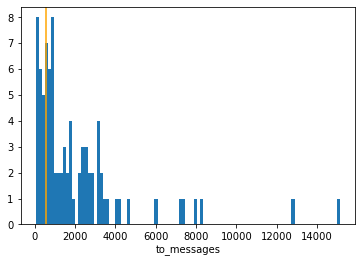

Text(0.5, 0, 'from_poi_to_this_person')

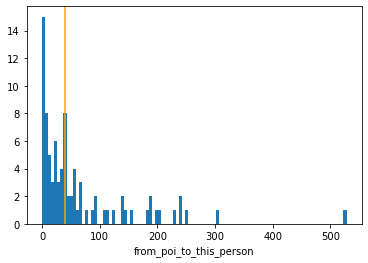

Text(0.5, 0, 'from_messages')

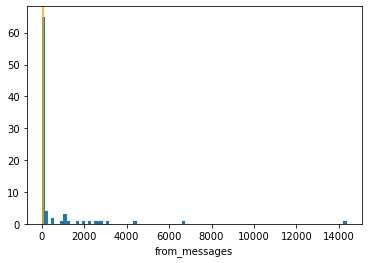

Text(0.5, 0, 'from_this_person_to_poi')

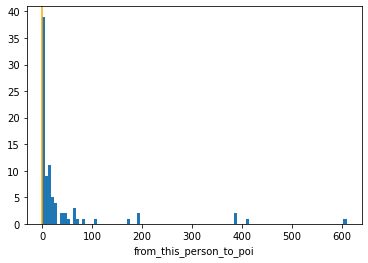

Text(0.5, 0, 'shared_receipt_with_poi')

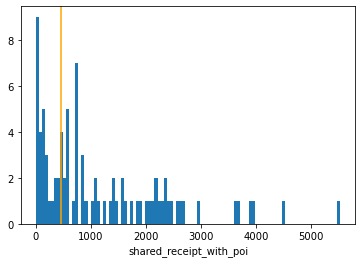

Text(0.5, 0, 'salary')

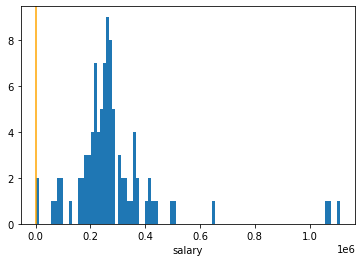

In [30]:
n, bins, patches = plt.hist(data_df['to_messages'], bins=100)
plt.axvline(x=data_df.loc['BANNANTINE JAMES M', 'to_messages'], color='orange')
plt.xlabel('to_messages')
plt.show()

n, bins, patches = plt.hist(data_df['from_poi_to_this_person'], bins=100)
plt.axvline(x=data_df.loc['BANNANTINE JAMES M', 'from_poi_to_this_person'],
            color='orange')
plt.xlabel('from_poi_to_this_person')
plt.show()

n, bins, patches = plt.hist(data_df['from_messages'], bins=100)#,
#                            range=(0, 2000))
plt.axvline(x=data_df.loc['BANNANTINE JAMES M', 'from_messages'],
            color='orange')
plt.xlabel('from_messages')
plt.show()

n, bins, patches = plt.hist(data_df['from_this_person_to_poi'], bins=100)#,
#                            range=(0, 100))
plt.axvline(x=data_df.loc['BANNANTINE JAMES M', 'from_this_person_to_poi'],
            color='orange')
plt.xlabel('from_this_person_to_poi')
plt.show()

n, bins, patches = plt.hist(data_df['shared_receipt_with_poi'], bins=100)
plt.axvline(x=data_df.loc['BANNANTINE JAMES M', 'shared_receipt_with_poi'],
            color='orange')
plt.xlabel('shared_receipt_with_poi')
plt.show()

n, bins, patches = plt.hist(data_df['salary'], bins=100)
plt.axvline(x=data_df.loc['BANNANTINE JAMES M', 'salary'],
            color='orange')
plt.xlabel('salary')
plt.show()

But, he's really not out of the normal on any of these values except salary.

It seems like the email values may have gotten shifted and slid into salary, with from_this_person_to_poi on the other end getting set to 0, but what was the original order? The dictionary key order is jumbled, and hard to believe a shift in any direction is more accurate.

I'm reluctant to guess a logical order of the email fields and make the shift and add the value from salary. For all I know, this is the correct data, or my fix will add more noise. 

I'll leave it as is for now and handle it when I handle all the outliers, probably set it to NaN or bottom code it, since I'm reluctant to lose this record with so few NaNs.

In [31]:
for feature, max_val in data_df.describe().loc['max'].items():
    print('Max', feature, ':', max_val)
    print('Person:', data_df[data_df[feature] == max_val].index)

Max poi : 1.0
Person: Index(['HANNON KEVIN P', 'COLWELL WESLEY', 'RIEKER PAULA H',
       'KOPPER MICHAEL J', 'SHELBY REX', 'DELAINEY DAVID W', 'LAY KENNETH L',
       'BOWEN JR RAYMOND M', 'BELDEN TIMOTHY N', 'FASTOW ANDREW S',
       'CALGER CHRISTOPHER F', 'RICE KENNETH D', 'SKILLING JEFFREY K',
       'YEAGER F SCOTT', 'HIRKO JOSEPH', 'KOENIG MARK E', 'CAUSEY RICHARD A',
       'GLISAN JR BEN F'],
      dtype='object')
Max salary : 1111258.0
Person: Index(['SKILLING JEFFREY K'], dtype='object')
Max bonus : 8000000.0
Person: Index(['LAVORATO JOHN J'], dtype='object')
Max long_term_incentive : 5145434.0
Person: Index(['MARTIN AMANDA K'], dtype='object')
Max deferred_income : -833.0
Person: Index(['BOWEN JR RAYMOND M'], dtype='object')
Max deferral_payments : 6426990.0
Person: Index(['FREVERT MARK A'], dtype='object')
Max loan_advances : 81525000.0
Person: Index(['LAY KENNETH L'], dtype='object')
Max other : 10359729.0
Person: Index(['LAY KENNETH L'], dtype='object')
Max expenses : 22

In [32]:
### Check POIs and nonPOIs against list of POIs.
full_POI_last_lst = ['LAY', 'SKILLING', 'HOWARD', 'KRAUTZ', 'YEAGER', 'HIRKO',
                     'SHELBY', 'BERMINGHAM', 'DARBY', 'MULGREW', 'BAYLEY',
                     'BROWN', 'FURST', 'FUHS', 'CAUSEY', 'CALGER', 'DESPAIN',
                     'HANNON', 'KOENIG', 'FORNEY', 'RICE', 'RIEKER', 'FASTOW',
                     'DELAINEY', 'GLISAN', 'RICHTER', 'LAWYER', 'BELDEN',
                     'KOPPER', 'DUNCAN', 'BOWEN', 'COLWELL', 'BOYLE', 'LOEHR']
POIs_in_set_lst = data_df[data_df['poi'] == 1].index.values
POIs_in_set_lst
nonPOIs_lst = data_df[data_df['poi'] == 0].index.values

array(['HANNON KEVIN P', 'COLWELL WESLEY', 'RIEKER PAULA H',
       'KOPPER MICHAEL J', 'SHELBY REX', 'DELAINEY DAVID W',
       'LAY KENNETH L', 'BOWEN JR RAYMOND M', 'BELDEN TIMOTHY N',
       'FASTOW ANDREW S', 'CALGER CHRISTOPHER F', 'RICE KENNETH D',
       'SKILLING JEFFREY K', 'YEAGER F SCOTT', 'HIRKO JOSEPH',
       'KOENIG MARK E', 'CAUSEY RICHARD A', 'GLISAN JR BEN F'],
      dtype=object)

In [33]:
non_labeled_poi = [non for non in nonPOIs_lst \
                   if non.split()[0] in full_POI_last_lst]
print("Potential false negatives")
non_labeled_poi
poi_labeled_non = [poi for poi in POIs_in_set_lst \
                   if poi.split()[0] not in full_POI_last_lst]
print('Potential false positives')
poi_labeled_non

Potential false negatives


['DUNCAN JOHN H', 'BROWN MICHAEL']

Potential false positives


[]

In [34]:
### Remove features that don't have enough nonNaNs.
data_df.count()
data_df[data_df['poi'] == 0].count()
data_df[data_df['poi'] == 1].count()

poi                          144
salary                        94
bonus                         81
long_term_incentive           65
deferred_income               49
deferral_payments             37
loan_advances                  3
other                         90
expenses                      96
director_fees                 15
total_payments               125
exercised_stock_options      100
restricted_stock             110
restricted_stock_deferred     17
total_stock_value            128
to_messages                   86
from_poi_to_this_person       86
from_messages                 86
from_this_person_to_poi       86
shared_receipt_with_poi       86
dtype: int64

poi                          126
salary                        77
bonus                         65
long_term_incentive           53
deferred_income               38
deferral_payments             32
loan_advances                  2
other                         72
expenses                      78
director_fees                 15
total_payments               107
exercised_stock_options       88
restricted_stock              93
restricted_stock_deferred     17
total_stock_value            110
to_messages                   72
from_poi_to_this_person       72
from_messages                 72
from_this_person_to_poi       72
shared_receipt_with_poi       72
dtype: int64

poi                          18
salary                       17
bonus                        16
long_term_incentive          12
deferred_income              11
deferral_payments             5
loan_advances                 1
other                        18
expenses                     18
director_fees                 0
total_payments               18
exercised_stock_options      12
restricted_stock             17
restricted_stock_deferred     0
total_stock_value            18
to_messages                  14
from_poi_to_this_person      14
from_messages                14
from_this_person_to_poi      14
shared_receipt_with_poi      14
dtype: int64

I'm going to leave those features that contain no/low nonNaN counts in either class because I'm still undecided what to do about these. For instance, if some financial NaNs are legitimately 0s, it might be telling that a person had restricted stock but none deferred.

In [35]:
### Drop features that are too sparse.
drop_feats_lst = ['loan_advances']
data_df.drop(columns=drop_feats_lst, inplace=True)

In [36]:
fin_features = [feat for feat in fin_features if feat not in drop_feats_lst]
pay_features = [feat for feat in pay_features if feat not in drop_feats_lst]
stock_features = [feat for feat in stock_features if feat not in drop_feats_lst]
email_features = [feat for feat in email_features if feat not in drop_feats_lst]
features_list = [feat for feat in features_list if feat not in drop_feats_lst]

I want to remove those records lacking essential data (totals) and high in NaNs (70%). I could just remove every record with 70% NaNs, but I want to leave them in if they aren't lacking essential information.

In [37]:
### Persons who have NaN payment totals or NaN stock totals
### or NaN to_messages or NaN from_messages,
### and are missing 70% of their values.
### (Already made sure that all totals are not NaN if they have subvalues.)
nan_limit = 0.7 * len(data_df.columns)
sparse_records_idx_arr = data_df.loc[data_df['total_payments'].isna() \
                                 | data_df['total_stock_value'].isna() \
                                 | data_df['to_messages'].isna() \
                                 | data_df['from_messages'].isna()]\
                        .loc[data_df.isna().sum(axis='columns') > nan_limit]\
                        .index.values
data_df.loc[data_df['total_payments'].isna() \
            | data_df['total_stock_value'].isna() \
            | data_df['to_messages'].isna() \
            | data_df['from_messages'].isna()]\
       .loc[data_df.isna().sum(axis='columns') > nan_limit]

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi,shared_receipt_with_poi
LOWRY CHARLES P,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,372205.0,153686.0,-153686.0,372205.0,NaN,NaN,NaN,NaN,NaN
WODRASKA JOHN,0,NaN,NaN,NaN,NaN,NaN,189583.0,NaN,NaN,189583.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
URQUHART JOHN A,0,NaN,NaN,NaN,-36666.0,NaN,NaN,228656.0,36666.0,228656.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WHALEY DAVID A,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98718.0,NaN,NaN,98718.0,NaN,NaN,NaN,NaN,NaN
MENDELSOHN JOHN,0,NaN,NaN,NaN,-103750.0,NaN,NaN,148.0,103750.0,148.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLINE KENNETH W,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,662086.0,-472568.0,189518.0,NaN,NaN,NaN,NaN,NaN
WAKEHAM JOHN,0,NaN,NaN,NaN,NaN,NaN,NaN,103773.0,109298.0,213071.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WROBEL BRUCE,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,139130.0,NaN,NaN,139130.0,NaN,NaN,NaN,NaN,NaN
MEYER JEROME J,0,NaN,NaN,NaN,-38346.0,NaN,NaN,2151.0,38346.0,2151.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GATHMANN WILLIAM D,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1753766.0,264013.0,-72419.0,1945360.0,NaN,NaN,NaN,NaN,NaN


LOCKHART EUGENE E is NaN across the board. All members of this set are missing all of their email data.

In [38]:
data_df.drop(labels=sparse_records_idx_arr, inplace=True)

In [39]:
# data_df.loc[sparse_records_idx_arr]
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123 entries, METTS MARK to GLISAN JR BEN F
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   poi                        123 non-null    int32  
 1   salary                     94 non-null     float64
 2   bonus                      81 non-null     float64
 3   long_term_incentive        65 non-null     float64
 4   deferred_income            42 non-null     float64
 5   deferral_payments          36 non-null     float64
 6   other                      89 non-null     float64
 7   expenses                   88 non-null     float64
 8   director_fees              6 non-null      float64
 9   total_payments             113 non-null    float64
 10  exercised_stock_options    91 non-null     float64
 11  restricted_stock           105 non-null    float64
 12  restricted_stock_deferred  14 non-null     float64
 13  total_stock_value          118 non

In [40]:
with open('data_df_cleaned.pkl', 'wb') as file:
    pickle.dump(obj=data_df, file=file)
    
with open('fin_features.pkl', 'wb') as file:
    pickle.dump(obj=fin_features, file=file)
with open('pay_features.pkl', 'wb') as file:
    pickle.dump(obj=pay_features, file=file)
with open('stock_features.pkl', 'wb') as file:
    pickle.dump(obj=stock_features, file=file)
with open('email_features.pkl', 'wb') as file:
    pickle.dump(obj=email_features, file=file)
with open('features_list.pkl', 'wb') as file:
    pickle.dump(obj=features_list, file=file)

In [41]:
test_df = None

with open('data_df_cleaned.pkl', 'rb') as file:
    test_df = pickle.load(file=file)

test_df.info() == data_df.info()
test_df.describe() ==  data_df.describe()

del test_df

<class 'pandas.core.frame.DataFrame'>
Index: 123 entries, METTS MARK to GLISAN JR BEN F
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   poi                        123 non-null    int32  
 1   salary                     94 non-null     float64
 2   bonus                      81 non-null     float64
 3   long_term_incentive        65 non-null     float64
 4   deferred_income            42 non-null     float64
 5   deferral_payments          36 non-null     float64
 6   other                      89 non-null     float64
 7   expenses                   88 non-null     float64
 8   director_fees              6 non-null      float64
 9   total_payments             113 non-null    float64
 10  exercised_stock_options    91 non-null     float64
 11  restricted_stock           105 non-null    float64
 12  restricted_stock_deferred  14 non-null     float64
 13  total_stock_value          118 non

True

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi,shared_receipt_with_poi
count,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
mean,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
std,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
min,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
25%,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
50%,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
75%,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
max,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


### Imputing to zero for baseline

In [42]:
imp_0 = SimpleImputer(missing_values=np.nan, strategy='constant',
                      fill_value=0, copy=False, add_indicator=True)
imp_0.fit(X=data_df)
data_imp0_arr = imp_0.transform(X=data_df)

data_imp0_arr
data_df.head()

SimpleImputer(add_indicator=True, copy=False, fill_value=0, strategy='constant')

array([[0.00000e+00, 3.65788e+05, 6.00000e+05, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [0.00000e+00, 2.67102e+05, 1.20000e+06, ..., 1.00000e+00,
        1.00000e+00, 1.00000e+00],
       [0.00000e+00, 1.70941e+05, 3.50000e+05, ..., 1.00000e+00,
        1.00000e+00, 1.00000e+00],
       ...,
       [0.00000e+00, 2.65214e+05, 6.00000e+05, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [0.00000e+00, 2.78601e+05, 8.00000e+05, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00000e+00, 2.74975e+05, 6.00000e+05, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi,shared_receipt_with_poi
METTS MARK,0,365788.0,600000.0,NaN,NaN,NaN,1740.0,94299.0,NaN,1061827.0,NaN,585062.0,NaN,585062.0,807.0,38.0,29.0,1.0,702.0
BAXTER JOHN C,0,267102.0,1200000.0,1586055.0,-1386055.0,1295738.0,2660303.0,11200.0,NaN,5634343.0,6680544.0,3942714.0,NaN,10623258.0,NaN,NaN,NaN,NaN,NaN
ELLIOTT STEVEN,0,170941.0,350000.0,NaN,-400729.0,NaN,12961.0,78552.0,NaN,211725.0,4890344.0,1788391.0,NaN,6678735.0,NaN,NaN,NaN,NaN,NaN
CORDES WILLIAM R,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,651850.0,386335.0,NaN,1038185.0,764.0,10.0,12.0,0.0,58.0
HANNON KEVIN P,1,243293.0,1500000.0,1617011.0,-3117011.0,NaN,11350.0,34039.0,NaN,288682.0,5538001.0,853064.0,NaN,6391065.0,1045.0,32.0,32.0,21.0,1035.0


In [43]:
columns_with_missingness = list(data_df.columns)
for col in data_df.columns[1:]:
    columns_with_missingness.append('missing_'+col)
columns_with_missingness

['poi',
 'salary',
 'bonus',
 'long_term_incentive',
 'deferred_income',
 'deferral_payments',
 'other',
 'expenses',
 'director_fees',
 'total_payments',
 'exercised_stock_options',
 'restricted_stock',
 'restricted_stock_deferred',
 'total_stock_value',
 'to_messages',
 'from_poi_to_this_person',
 'from_messages',
 'from_this_person_to_poi',
 'shared_receipt_with_poi',
 'missing_salary',
 'missing_bonus',
 'missing_long_term_incentive',
 'missing_deferred_income',
 'missing_deferral_payments',
 'missing_other',
 'missing_expenses',
 'missing_director_fees',
 'missing_total_payments',
 'missing_exercised_stock_options',
 'missing_restricted_stock',
 'missing_restricted_stock_deferred',
 'missing_total_stock_value',
 'missing_to_messages',
 'missing_from_poi_to_this_person',
 'missing_from_messages',
 'missing_from_this_person_to_poi',
 'missing_shared_receipt_with_poi']

In [44]:
data_imp0_with_miss_df = pd.DataFrame(data_imp0_arr,
                            columns=columns_with_missingness,
                            index=data_df.index)

In [45]:
### Make sure I've paired the right features with their missingness columns.
for col in features_list[1:]:
    data_imp0_with_miss_df[[col, ('missing_'+col)]].head()

,salary,missing_salary
METTS MARK,365788.0,0.0
BAXTER JOHN C,267102.0,0.0
ELLIOTT STEVEN,170941.0,0.0
CORDES WILLIAM R,0.0,1.0
HANNON KEVIN P,243293.0,0.0


,bonus,missing_bonus
METTS MARK,600000.0,0.0
BAXTER JOHN C,1200000.0,0.0
ELLIOTT STEVEN,350000.0,0.0
CORDES WILLIAM R,0.0,1.0
HANNON KEVIN P,1500000.0,0.0


,long_term_incentive,missing_long_term_incentive
METTS MARK,0.0,1.0
BAXTER JOHN C,1586055.0,0.0
ELLIOTT STEVEN,0.0,1.0
CORDES WILLIAM R,0.0,1.0
HANNON KEVIN P,1617011.0,0.0


,deferred_income,missing_deferred_income
METTS MARK,0.0,1.0
BAXTER JOHN C,-1386055.0,0.0
ELLIOTT STEVEN,-400729.0,0.0
CORDES WILLIAM R,0.0,1.0
HANNON KEVIN P,-3117011.0,0.0


,deferral_payments,missing_deferral_payments
METTS MARK,0.0,1.0
BAXTER JOHN C,1295738.0,0.0
ELLIOTT STEVEN,0.0,1.0
CORDES WILLIAM R,0.0,1.0
HANNON KEVIN P,0.0,1.0


,other,missing_other
METTS MARK,1740.0,0.0
BAXTER JOHN C,2660303.0,0.0
ELLIOTT STEVEN,12961.0,0.0
CORDES WILLIAM R,0.0,1.0
HANNON KEVIN P,11350.0,0.0


,expenses,missing_expenses
METTS MARK,94299.0,0.0
BAXTER JOHN C,11200.0,0.0
ELLIOTT STEVEN,78552.0,0.0
CORDES WILLIAM R,0.0,1.0
HANNON KEVIN P,34039.0,0.0


,director_fees,missing_director_fees
METTS MARK,0.0,1.0
BAXTER JOHN C,0.0,1.0
ELLIOTT STEVEN,0.0,1.0
CORDES WILLIAM R,0.0,1.0
HANNON KEVIN P,0.0,1.0


,total_payments,missing_total_payments
METTS MARK,1061827.0,0.0
BAXTER JOHN C,5634343.0,0.0
ELLIOTT STEVEN,211725.0,0.0
CORDES WILLIAM R,0.0,1.0
HANNON KEVIN P,288682.0,0.0


,exercised_stock_options,missing_exercised_stock_options
METTS MARK,0.0,1.0
BAXTER JOHN C,6680544.0,0.0
ELLIOTT STEVEN,4890344.0,0.0
CORDES WILLIAM R,651850.0,0.0
HANNON KEVIN P,5538001.0,0.0


,restricted_stock,missing_restricted_stock
METTS MARK,585062.0,0.0
BAXTER JOHN C,3942714.0,0.0
ELLIOTT STEVEN,1788391.0,0.0
CORDES WILLIAM R,386335.0,0.0
HANNON KEVIN P,853064.0,0.0


,restricted_stock_deferred,missing_restricted_stock_deferred
METTS MARK,0.0,1.0
BAXTER JOHN C,0.0,1.0
ELLIOTT STEVEN,0.0,1.0
CORDES WILLIAM R,0.0,1.0
HANNON KEVIN P,0.0,1.0


,total_stock_value,missing_total_stock_value
METTS MARK,585062.0,0.0
BAXTER JOHN C,10623258.0,0.0
ELLIOTT STEVEN,6678735.0,0.0
CORDES WILLIAM R,1038185.0,0.0
HANNON KEVIN P,6391065.0,0.0


,to_messages,missing_to_messages
METTS MARK,807.0,0.0
BAXTER JOHN C,0.0,1.0
ELLIOTT STEVEN,0.0,1.0
CORDES WILLIAM R,764.0,0.0
HANNON KEVIN P,1045.0,0.0


,from_poi_to_this_person,missing_from_poi_to_this_person
METTS MARK,38.0,0.0
BAXTER JOHN C,0.0,1.0
ELLIOTT STEVEN,0.0,1.0
CORDES WILLIAM R,10.0,0.0
HANNON KEVIN P,32.0,0.0


,from_messages,missing_from_messages
METTS MARK,29.0,0.0
BAXTER JOHN C,0.0,1.0
ELLIOTT STEVEN,0.0,1.0
CORDES WILLIAM R,12.0,0.0
HANNON KEVIN P,32.0,0.0


,from_this_person_to_poi,missing_from_this_person_to_poi
METTS MARK,1.0,0.0
BAXTER JOHN C,0.0,1.0
ELLIOTT STEVEN,0.0,1.0
CORDES WILLIAM R,0.0,0.0
HANNON KEVIN P,21.0,0.0


,shared_receipt_with_poi,missing_shared_receipt_with_poi
METTS MARK,702.0,0.0
BAXTER JOHN C,0.0,1.0
ELLIOTT STEVEN,0.0,1.0
CORDES WILLIAM R,58.0,0.0
HANNON KEVIN P,1035.0,0.0


In [46]:
### See data types
data_imp0_with_miss_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123 entries, METTS MARK to GLISAN JR BEN F
Data columns (total 37 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   poi                                123 non-null    float64
 1   salary                             123 non-null    float64
 2   bonus                              123 non-null    float64
 3   long_term_incentive                123 non-null    float64
 4   deferred_income                    123 non-null    float64
 5   deferral_payments                  123 non-null    float64
 6   other                              123 non-null    float64
 7   expenses                           123 non-null    float64
 8   director_fees                      123 non-null    float64
 9   total_payments                     123 non-null    float64
 10  exercised_stock_options            123 non-null    float64
 11  restricted_stock                   123 non

In [47]:
data_imp0_df = data_imp0_with_miss_df[features_list]
data_imp0_df.head()

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi,shared_receipt_with_poi
METTS MARK,0.0,365788.0,600000.0,0.0,0.0,0.0,1740.0,94299.0,0.0,1061827.0,0.0,585062.0,0.0,585062.0,807.0,38.0,29.0,1.0,702.0
BAXTER JOHN C,0.0,267102.0,1200000.0,1586055.0,-1386055.0,1295738.0,2660303.0,11200.0,0.0,5634343.0,6680544.0,3942714.0,0.0,10623258.0,0.0,0.0,0.0,0.0,0.0
ELLIOTT STEVEN,0.0,170941.0,350000.0,0.0,-400729.0,0.0,12961.0,78552.0,0.0,211725.0,4890344.0,1788391.0,0.0,6678735.0,0.0,0.0,0.0,0.0,0.0
CORDES WILLIAM R,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,651850.0,386335.0,0.0,1038185.0,764.0,10.0,12.0,0.0,58.0
HANNON KEVIN P,1.0,243293.0,1500000.0,1617011.0,-3117011.0,0.0,11350.0,34039.0,0.0,288682.0,5538001.0,853064.0,0.0,6391065.0,1045.0,32.0,32.0,21.0,1035.0


In [48]:
with open('data_imp0_with_miss_df.pkl', 'wb') as file:
    pickle.dump(obj=data_imp0_with_miss_df, file=file)
with open('data_imp0_df.pkl', 'wb') as file:
    pickle.dump(obj=data_imp0_df, file=file)

### Baseline models
NaNs imputed with 0, no scaling or anything.

It should be noted that I'm using the full data set here split (minus removed records). If I were considering these models for use, I would need to validate the results with a further test set to avoid "dredging" the data or needing to apply something akin to Bonferroni's Correction.

As it is, I am just creating baseline metrics to measure my final model against, not selecting from these models. It might be better if I were blind to these metrics going into the rest of the process. A more conservative approach would be to run my baselines at the end after I've selected my final model, but I want to make sure it runs.

In [49]:
X_train, X_test, y_train, y_test = \
    train_test_split(data_imp0_df[features_list[1:]],
                     data_imp0_df[['poi']],
                     test_size=.3, random_state=42)

In [50]:
def run_skl(method, X_train, y_train, X_test, y_test, print_perf=True,
            perf_series='', **kwargs):
    '''Train and test sklearn supervised ML models.
    ### Borrowed and modified from Udacity. ###
    ### Needs `from class_vis import prettyPicture` to graph. ###
    Parameters:
        method: callable sklearn supervised ML model.
        X_train: training feature matrix.
        y_train: training label 1D array. Series may throw warning.
        X_test: testing feature matrix.
        y_test: testing label 1D array. Series may throw warning.
        print_perf: {bool} True (default) prints performance metrics.
        per_series: {str} (default is empty) If not empty,
                    returns pandas Series with model and performance metrics.
                    String value is name of series.
        **kwargs: arguments to pass to method.
    Returns:
        clf: trained model.
        pred: array of predictions.
        conf: confusion matrix of test results.
        prf: sklearn.metrics.precision_recall_fscore_support results, weighted.
        perf_sr: pandas Series of model and metrics (everything but pred).
                 Must be binary class. Returns as None if perf_series False.
    '''
    clf = None
    pred = None
    conf = None
    prf = None
    perf_sr = None
    
    clf = method(**kwargs)

    t0 = time()
    clf = clf.fit(X=X_train, y=y_train)
    train_t = round(time()-t0, 3)
    
    t0 = time()
    pred = clf.predict(X=X_test)
    pred_t = round(time()-t0, 3)
    
    conf = confusion_matrix(y_true=y_test, y_pred=pred)
    prf = precision_recall_fscore_support(y_true=y_test, y_pred=pred)
    
###
### TO DO: fix from class_vis import prettyPicture
###
#     try:
#         prettyPicture(clf, X_test, y_test)
#     except NameError:
#         pass
    
    if print_perf:
        print(clf)
        print("Training time:", train_t, "s")
        print("Prediction time:", pred_t, "s")
        print("Confusion matrix:\n", conf)
        print("Precision, recall, f beta score, support:\n", prf)
    
    if perf_series != '':
        perf_sr = pd.Series(
            {
                'model': clf,
                'nonPOI_prec': prf[0][0],
                'POI_prec': prf[0][1],
                'nonPOI_rec': prf[1][0],
                'POI_rec': prf[1][1],
                'nonPOI_f': prf[2][0],
                'POI_f': prf[2][1],
                'nonPOI_sup': prf[3][0],
                'POI_sup': prf[3][1],
                't_neg': conf[0][0],
                'f_neg': conf[0][1],
                'f_pos': conf[1][0],
                't_pos': conf[1][1],
                'train_t': train_t,
                'predict_t': pred_t,
            },
            name=perf_series
        )
    
    return clf, pred, conf, prf, perf_sr

ordered_cols_lst = ['nonPOI_prec', 'POI_prec', 'nonPOI_rec', 'POI_rec',
                    'nonPOI_f', 'POI_f', 'nonPOI_sup', 'POI_sup', 't_neg',
                    'f_neg', 'f_pos', 't_pos', 'train_t', 'predict_t', 'model']
base_perf_df = pd.DataFrame(columns=ordered_cols_lst)

y_train_1d = np.ravel(y_train)
y_test_1d = np.ravel(y_test)

In [51]:
_, _, _, _, perf_sr = run_skl(method=DecisionTreeClassifier,
                              X_train=X_train, y_train=y_train,
                              X_test=X_test, y_test=y_test,
                              perf_series='dt_clf')
base_perf_df = base_perf_df.append(perf_sr)

DecisionTreeClassifier()
Training time: 0.0 s
Prediction time: 0.0 s
Confusion matrix:
 [[28  3]
 [ 4  2]]
Precision, recall, f beta score, support:
 (array([0.875, 0.4  ]), array([0.90322581, 0.33333333]), array([0.88888889, 0.36363636]), array([31,  6], dtype=int64))


In [52]:
_, _, _, _, perf_sr = run_skl(method=RandomForestClassifier,
                              X_train=X_train, y_train=y_train_1d,
                              X_test=X_test, y_test=y_test_1d,
                              perf_series='rf_clf')
base_perf_df = base_perf_df.append(perf_sr)

RandomForestClassifier()
Training time: 0.096 s
Prediction time: 0.003 s
Confusion matrix:
 [[31  0]
 [ 4  2]]
Precision, recall, f beta score, support:
 (array([0.88571429, 1.        ]), array([1.        , 0.33333333]), array([0.93939394, 0.5       ]), array([31,  6], dtype=int64))


In [53]:
_, _, _, _, perf_sr = run_skl(method=AdaBoostClassifier,
                              X_train=X_train, y_train=y_train_1d,
                              X_test=X_test, y_test=y_test_1d,
                              perf_series='ab_clf')
base_perf_df = base_perf_df.append(perf_sr)

AdaBoostClassifier()
Training time: 0.047 s
Prediction time: 0.0 s
Confusion matrix:
 [[28  3]
 [ 4  2]]
Precision, recall, f beta score, support:
 (array([0.875, 0.4  ]), array([0.90322581, 0.33333333]), array([0.88888889, 0.36363636]), array([31,  6], dtype=int64))


In [54]:
_, _, _, _, perf_sr = run_skl(method=KNeighborsClassifier,
                              X_train=X_train, y_train=y_train_1d,
                              X_test=X_test, y_test=y_test_1d,
                              perf_series='kn_clf')
base_perf_df = base_perf_df.append(perf_sr)

KNeighborsClassifier()
Training time: 0.0 s
Prediction time: 0.0 s
Confusion matrix:
 [[31  0]
 [ 5  1]]
Precision, recall, f beta score, support:
 (array([0.86111111, 1.        ]), array([1.        , 0.16666667]), array([0.92537313, 0.28571429]), array([31,  6], dtype=int64))


In [55]:
_, _, _, _, perf_sr = run_skl(method=GaussianNB,
                              X_train=X_train, y_train=y_train_1d,
                              X_test=X_test, y_test=y_test_1d,
                              perf_series='gnb_clf')
base_perf_df = base_perf_df.append(perf_sr)

GaussianNB()
Training time: 0.0 s
Prediction time: 0.0 s
Confusion matrix:
 [[10 21]
 [ 2  4]]
Precision, recall, f beta score, support:
 (array([0.83333333, 0.16      ]), array([0.32258065, 0.66666667]), array([0.46511628, 0.25806452]), array([31,  6], dtype=int64))


In [56]:
_, _, _, _, perf_sr = run_skl(method=svm.SVC,
                              X_train=X_train, y_train=y_train_1d,
                              X_test=X_test, y_test=y_test_1d,
                              perf_series='svc_clf')
base_perf_df = base_perf_df.append(perf_sr)

SVC()
Training time: 0.005 s
Prediction time: 0.002 s
Confusion matrix:
 [[31  0]
 [ 6  0]]
Precision, recall, f beta score, support:
 (array([0.83783784, 0.        ]), array([1., 0.]), array([0.91176471, 0.        ]), array([31,  6], dtype=int64))


C:\Users\kaleb\anaconda3\envs\py3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
base_perf_df

,nonPOI_prec,POI_prec,nonPOI_rec,POI_rec,nonPOI_f,POI_f,nonPOI_sup,POI_sup,t_neg,f_neg,f_pos,t_pos,train_t,predict_t,model
dt_clf,0.875000,0.40,0.903226,0.333333,0.888889,0.363636,31,6,28,3,4,2,0.000,0.000,DecisionTreeClassifier()
rf_clf,0.885714,1.00,1.000000,0.333333,0.939394,0.500000,31,6,31,0,4,2,0.096,0.003,"(DecisionTreeClassifier(max_features='auto', r..."
ab_clf,0.875000,0.40,0.903226,0.333333,0.888889,0.363636,31,6,28,3,4,2,0.047,0.000,"(DecisionTreeClassifier(max_depth=1, random_st..."
kn_clf,0.861111,1.00,1.000000,0.166667,0.925373,0.285714,31,6,31,0,5,1,0.000,0.000,KNeighborsClassifier()
gnb_clf,0.833333,0.16,0.322581,0.666667,0.465116,0.258065,31,6,10,21,2,4,0.000,0.000,GaussianNB()
svc_clf,0.837838,0.00,1.000000,0.000000,0.911765,0.000000,31,6,31,0,6,0,0.005,0.002,SVC()


In [58]:
with open('base_perf_df.pkl', 'wb') as file:
    pickle.dump(obj=base_perf_df, file=file)

In [59]:
### Task 2: Remove outliers
### First, let's do some general EDA.


In [60]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [61]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

In [62]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

ModuleNotFoundError: No module named 'sklearn.cross_validation'

In [ ]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)